In [19]:
# CELL 1: Setup & Imports
"""
ROI Creation for Longitudinal Hemispherectomy Study
====================================================
Creates functional ROIs using Leave-One-Out approach in ses-01
Based on Liu et al. 2025 methodology

Author: Claire Simmons
Date: October 2025
"""

import numpy as np
import nibabel as nib
import pandas as pd
from scipy import ndimage
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
import os
warnings.filterwarnings('ignore')

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


In [2]:
# CELL 2: Configuration & Paths
"""
Define all paths, subjects, and ROI configuration
"""

# Base paths
BASE_DIR = Path('/user_data/csimmon2/long_pt')

# Subject configuration
SUBJECTS = {
    'sub-004': {
        'patient_code': 'UD',
        'resection': 'Right posterior VOTC',
        'intact_hemisphere': 'left',
        'primary_hemisphere': 'left'
    },
    'sub-007': {
        'patient_code': 'OT', 
        'resection': 'Left anterior temporal',
        'intact_hemisphere': 'left',
        'primary_hemisphere': 'left'
    },
    'sub-021': {
        'patient_code': 'TC',
        'resection': 'Left posterior VOTC & parietal',
        'intact_hemisphere': 'right',
        'primary_hemisphere': 'right'
    }
}

# ROI Configuration - ALL ROIS, BOTH HEMISPHERES
ROI_CONFIG = {
    'FFA': {
        'cope': 6, 
        'contrast': 'Face > All',
        'anatomical_target': 'Fusiform gyrus'
    },
    'PPA': {
        'cope': 7,
        'contrast': 'House > All', 
        'anatomical_target': 'Parahippocampal gyrus'
    },
    'LOC': {
        'cope': 8,
        'contrast': 'Object > All',
        'anatomical_target': 'Lateral occipital cortex'
    },
    'VWFA': {
        'cope': 9,
        'contrast': 'Word > All',
        'anatomical_target': 'Fusiform gyrus (left typical)'
    },
    'Face-Word_contrast': {
        'cope': 13,
        'contrast': 'Face > Word',
        'anatomical_target': 'VTOC'
    },
    'Object-House_contrast': {
        'cope': 14,
        'contrast': 'Object > House',
        'anatomical_target': 'VTOC'
    }
}

# Analysis parameters
HEMISPHERES = ['left', 'right']
SPHERE_RADII = [6, 8, 10]  # mm
Z_THRESHOLD = 2.3
SESSION = 'ses-01'  # Define ROIs in first session only

print(f"Configuration loaded:")
print(f"  Subjects: {list(SUBJECTS.keys())}")
print(f"  ROIs: {list(ROI_CONFIG.keys())}")
print(f"  Hemispheres: {HEMISPHERES}")
print(f"  Sphere radii: {SPHERE_RADII} mm")
print(f"  Z threshold: {Z_THRESHOLD}")
print(f"  Session for ROI definition: {SESSION}")

Configuration loaded:
  Subjects: ['sub-004', 'sub-007', 'sub-021']
  ROIs: ['FFA', 'PPA', 'LOC', 'VWFA', 'Face-Word_contrast', 'Object-House_contrast']
  Hemispheres: ['left', 'right']
  Sphere radii: [6, 8, 10] mm
  Z threshold: 2.3
  Session for ROI definition: ses-01



sub-004 (UD):
  Left VTOC: 261,457 voxels
  Right VTOC: 246,180 voxels

sub-007 (OT):
  Left VTOC: 252,710 voxels
  Right VTOC: 325,131 voxels

sub-021 (TC):
  Left VTOC: 208,637 voxels
  Right VTOC: 254,671 voxels


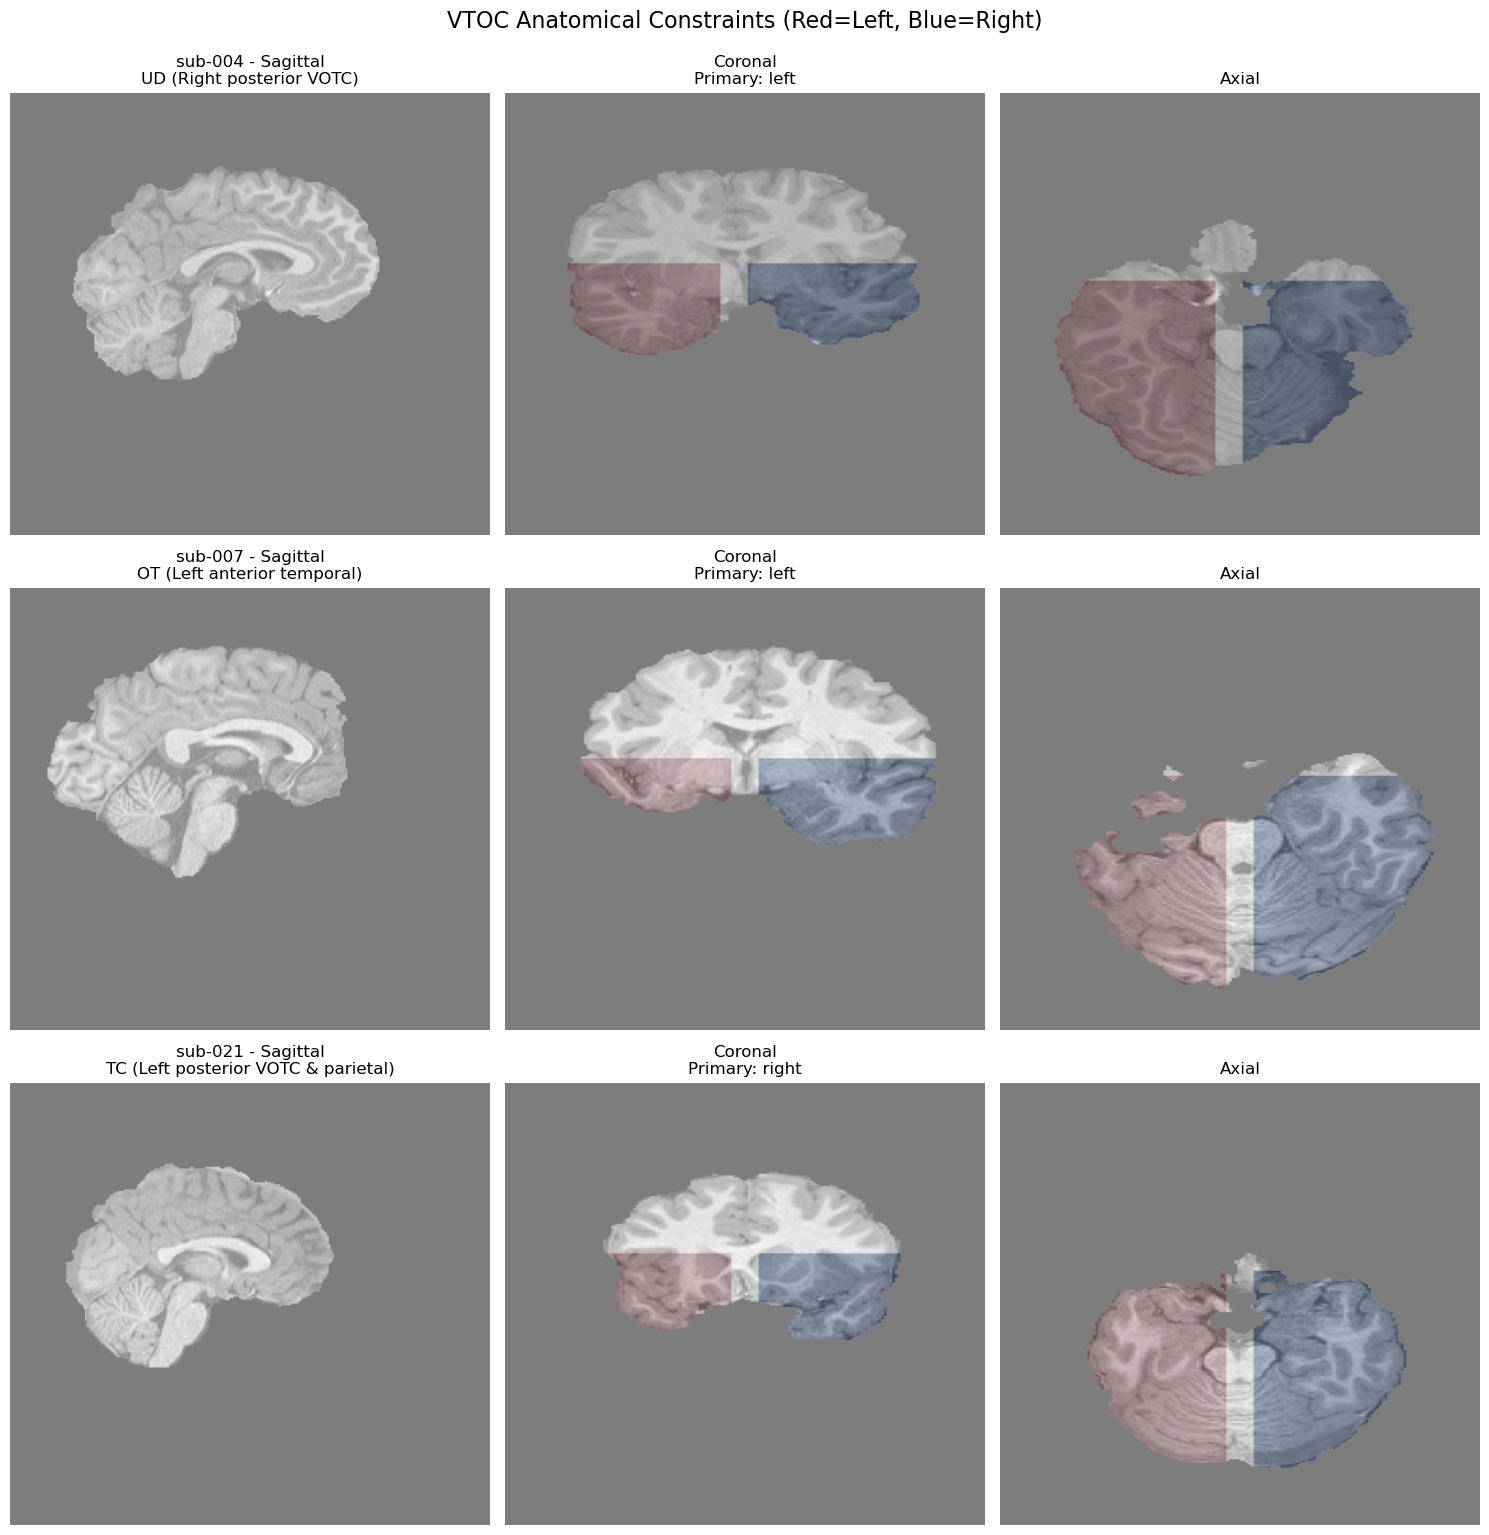


✓ VERIFY: Masks cover fusiform, parahippocampal, lateral occipital, inferior temporal


In [3]:
# CELL 3: Create & Visualize Anatomical Constraints (VTOC)
"""
Create ventral temporal-occipital cortex (VTOC) masks
Visualize on each subject's anatomy for verification
"""

def create_vtoc_mask(anat_img, hemisphere='left'):
    """
    Create VTOC anatomical constraint mask
    
    Parameters:
    -----------
    anat_img : nibabel image
        Anatomical image in subject space
    hemisphere : str
        'left' or 'right'
    
    Returns:
    --------
    vtoc_mask : 3D numpy array
        Binary mask of VTOC
    """
    # Get affine and shape
    affine = anat_img.affine
    shape = anat_img.shape
    
    # Create coordinate grids in mm space
    i, j, k = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        indexing='ij'
    )
    
    # Convert voxel indices to mm coordinates
    coords = np.stack([i.ravel(), j.ravel(), k.ravel(), np.ones(i.size)])
    mm_coords = affine @ coords
    X, Y, Z = mm_coords[0].reshape(shape), mm_coords[1].reshape(shape), mm_coords[2].reshape(shape)
    
    # Get brain mask (non-zero voxels)
    brain = anat_img.get_fdata() > 0
    
    # Hemisphere constraint
    if hemisphere == 'left':
        hemi_mask = (X < -5)
    else:
        hemi_mask = (X > 5)
    
    # VTOC boundaries (in mm)
    vtoc_mask = (
        hemi_mask &
        (Y > -110) & (Y < 20) &   # Posterior occipital to anterior temporal
        (Z > -60) & (Z < 30) &    # Inferior to superior
        brain
    )
    
    return vtoc_mask.astype(np.uint8)


# Create and visualize VTOC masks for all subjects
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, (subject, config) in enumerate(SUBJECTS.items()):
    # Load anatomical
    anat_path = BASE_DIR / subject / SESSION / 'anat' / f'{subject}_{SESSION}_T1w_brain.nii.gz'
    anat_img = nib.load(anat_path)
    anat_data = anat_img.get_fdata()
    
    # Create masks for both hemispheres
    left_mask = create_vtoc_mask(anat_img, 'left')
    right_mask = create_vtoc_mask(anat_img, 'right')
    
    # Get middle slices
    mid_sag = anat_data.shape[0] // 2
    mid_cor = anat_data.shape[1] // 2  
    mid_ax = anat_data.shape[2] // 2
    
    # Sagittal view
    ax = axes[idx, 0]
    ax.imshow(np.rot90(anat_data[mid_sag, :, :]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(left_mask[mid_sag, :, :]), cmap='Reds', alpha=0.3, aspect='auto')
    ax.imshow(np.rot90(right_mask[mid_sag, :, :]), cmap='Blues', alpha=0.3, aspect='auto')
    ax.set_title(f'{subject} - Sagittal\n{config["patient_code"]} ({config["resection"]})')
    ax.axis('off')
    
    # Coronal view
    ax = axes[idx, 1]
    ax.imshow(np.rot90(anat_data[:, mid_cor, :]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(left_mask[:, mid_cor, :]), cmap='Reds', alpha=0.3, aspect='auto')
    ax.imshow(np.rot90(right_mask[:, mid_cor, :]), cmap='Blues', alpha=0.3, aspect='auto')
    ax.set_title(f'Coronal\nPrimary: {config["primary_hemisphere"]}')
    ax.axis('off')
    
    # Axial view
    ax = axes[idx, 2]
    ax.imshow(np.rot90(anat_data[:, :, mid_ax]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(left_mask[:, :, mid_ax]), cmap='Reds', alpha=0.3, aspect='auto')
    ax.imshow(np.rot90(right_mask[:, :, mid_ax]), cmap='Blues', alpha=0.3, aspect='auto')
    ax.set_title('Axial')
    ax.axis('off')
    
    # Print statistics
    print(f"\n{subject} ({config['patient_code']}):")
    print(f"  Left VTOC: {left_mask.sum():,} voxels")
    print(f"  Right VTOC: {right_mask.sum():,} voxels")

plt.tight_layout()
plt.suptitle('VTOC Anatomical Constraints (Red=Left, Blue=Right)', y=1.02, fontsize=16)
plt.show()

print("\n✓ VERIFY: Masks cover fusiform, parahippocampal, lateral occipital, inferior temporal")

Checking: /user_data/csimmon2/long_pt/sub-004/ses-01/anat/HarvardOxford_cort_maxprob_sub-004_ses-01.nii.gz
Exists: True

Atlas shape: (176, 256, 256)
Atlas data type: int64

Unique labels in atlas: 49
Min label: 0
Max label: 48

Label distribution (top 20):
  Label   0: 10,733,381 voxels
  Label   1: 94,025 voxels
  Label  22: 59,770 voxels
  Label   7: 52,389 voxels
  Label  17: 42,220 voxels
  Label  31: 34,313 voxels
  Label   4: 32,512 voxels
  Label  48: 32,267 voxels
  Label   3: 31,022 voxels
  Label   8: 28,783 voxels
  Label  23: 25,008 voxels
  Label  36: 20,669 voxels
  Label  33: 19,254 voxels
  Label  28: 18,063 voxels
  Label  18: 17,712 voxels
  Label  29: 15,868 voxels
  Label  12: 15,407 voxels
  Label  30: 14,790 voxels
  Label  21: 14,722 voxels
  Label   2: 14,281 voxels

Expected LEFT labels present:
  ✓ Label 5: 6,703 voxels
  ✓ Label 6: 8,433 voxels
  ✓ Label 7: 52,389 voxels
  ✓ Label 11: 5,187 voxels
  ✓ Label 12: 15,407 voxels
  ✓ Label 13: 12,270 voxels
  ✓ L

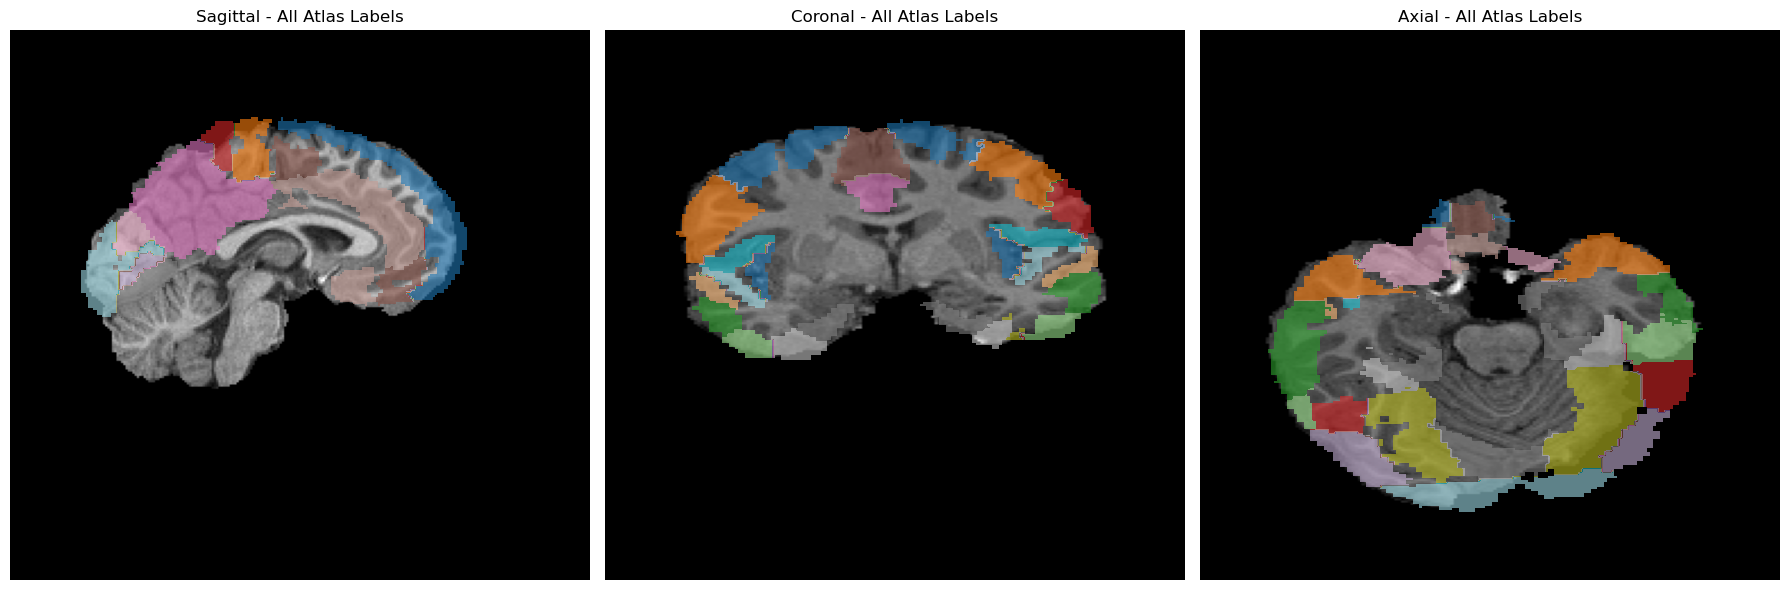

In [ ]:
# DEBUG CELL: Check what's in the registered atlas
# Create & Visualize Anatomical Constraints (VTOC)
"""
Inspect the registered Harvard-Oxford atlas to see what went wrong
"""

subject = 'sub-004'
atlas_path = BASE_DIR / subject / SESSION / 'anat' / f'HarvardOxford_cort_maxprob_{subject}_{SESSION}.nii.gz'

print(f"Checking: {atlas_path}")
print(f"Exists: {atlas_path.exists()}")

if atlas_path.exists():
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata().astype(int)
    
    print(f"\nAtlas shape: {atlas_data.shape}")
    print(f"Atlas data type: {atlas_data.dtype}")
    print(f"\nUnique labels in atlas: {len(np.unique(atlas_data))}")
    print(f"Min label: {atlas_data.min()}")
    print(f"Max label: {atlas_data.max()}")
    
    # Show histogram of labels
    unique, counts = np.unique(atlas_data, return_counts=True)
    print(f"\nLabel distribution (top 20):")
    sorted_idx = np.argsort(counts)[::-1][:20]
    for idx in sorted_idx:
        label = unique[idx]
        count = counts[idx]
        print(f"  Label {label:3d}: {count:,} voxels")
    
    # Check if expected labels exist
    expected_left = [5, 6, 7, 11, 12, 13, 17, 19, 20]
    expected_right = [53, 54, 55, 59, 60, 61, 65, 67, 68]
    
    print(f"\nExpected LEFT labels present:")
    for label in expected_left:
        count = (atlas_data == label).sum()
        status = "✓" if count > 0 else "✗"
        print(f"  {status} Label {label}: {count:,} voxels")
    
    print(f"\nExpected RIGHT labels present:")
    for label in expected_right:
        count = (atlas_data == label).sum()
        status = "✓" if count > 0 else "✗"
        print(f"  {status} Label {label}: {count:,} voxels")
    
    # Visualize what we actually have
    anat_path = BASE_DIR / subject / SESSION / 'anat' / f'{subject}_{SESSION}_T1w_brain.nii.gz'
    anat_img = nib.load(anat_path)
    anat_data = anat_img.get_fdata()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    mid_x = atlas_data.shape[0] // 2
    mid_y = atlas_data.shape[1] // 2
    mid_z = atlas_data.shape[2] // 2
    
    # Sagittal
    ax = axes[0]
    ax.imshow(anat_data[mid_x, :, :].T, cmap='gray', origin='lower', aspect='auto')
    ax.imshow(np.ma.masked_equal(atlas_data[mid_x, :, :].T, 0), cmap='tab20', alpha=0.6, origin='lower', aspect='auto')
    ax.set_title('Sagittal - All Atlas Labels')
    ax.axis('off')
    
    # Coronal
    ax = axes[1]
    ax.imshow(anat_data[:, mid_y, :].T, cmap='gray', origin='lower', aspect='auto')
    ax.imshow(np.ma.masked_equal(atlas_data[:, mid_y, :].T, 0), cmap='tab20', alpha=0.6, origin='lower', aspect='auto')
    ax.set_title('Coronal - All Atlas Labels')
    ax.axis('off')
    
    # Axial
    ax = axes[2]
    ax.imshow(anat_data[:, :, mid_z].T, cmap='gray', origin='lower', aspect='auto')
    ax.imshow(np.ma.masked_equal(atlas_data[:, :, mid_z].T, 0), cmap='tab20', alpha=0.6, origin='lower', aspect='auto')
    ax.set_title('Axial - All Atlas Labels')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("\n❌ Atlas file not found! Registration script may have failed.")
    print("Check the output of register_ho_atlas.sh")

DIAGNOSTIC: Harvard-Oxford Mask & Peak Finding

1. MASK CHECK:
   Requested hemisphere: left
   Mask voxels: 167,035
   Mask X range: -64.5 to 71.5 mm
   Expected for LEFT: negative values (X < -5)
   Expected for RIGHT: positive values (X > 5)
   ❌ ERROR: Mask extends into RIGHT hemisphere!

2. ZSTAT CHECK:
   Zstat shape: (176, 256, 256)
   Anat shape: (176, 256, 256)
   Mask shape: (176, 256, 256)
   Shapes match: True

3. THRESHOLDING:
   Voxels above Z=2.3: 3721
   Number of clusters: 47
   Largest cluster: 1922 voxels
   Peak voxel: (119, 120, 180)
   Peak mm: (35.5, -7.0, 53.0)
   Peak X hemisphere: RIGHT


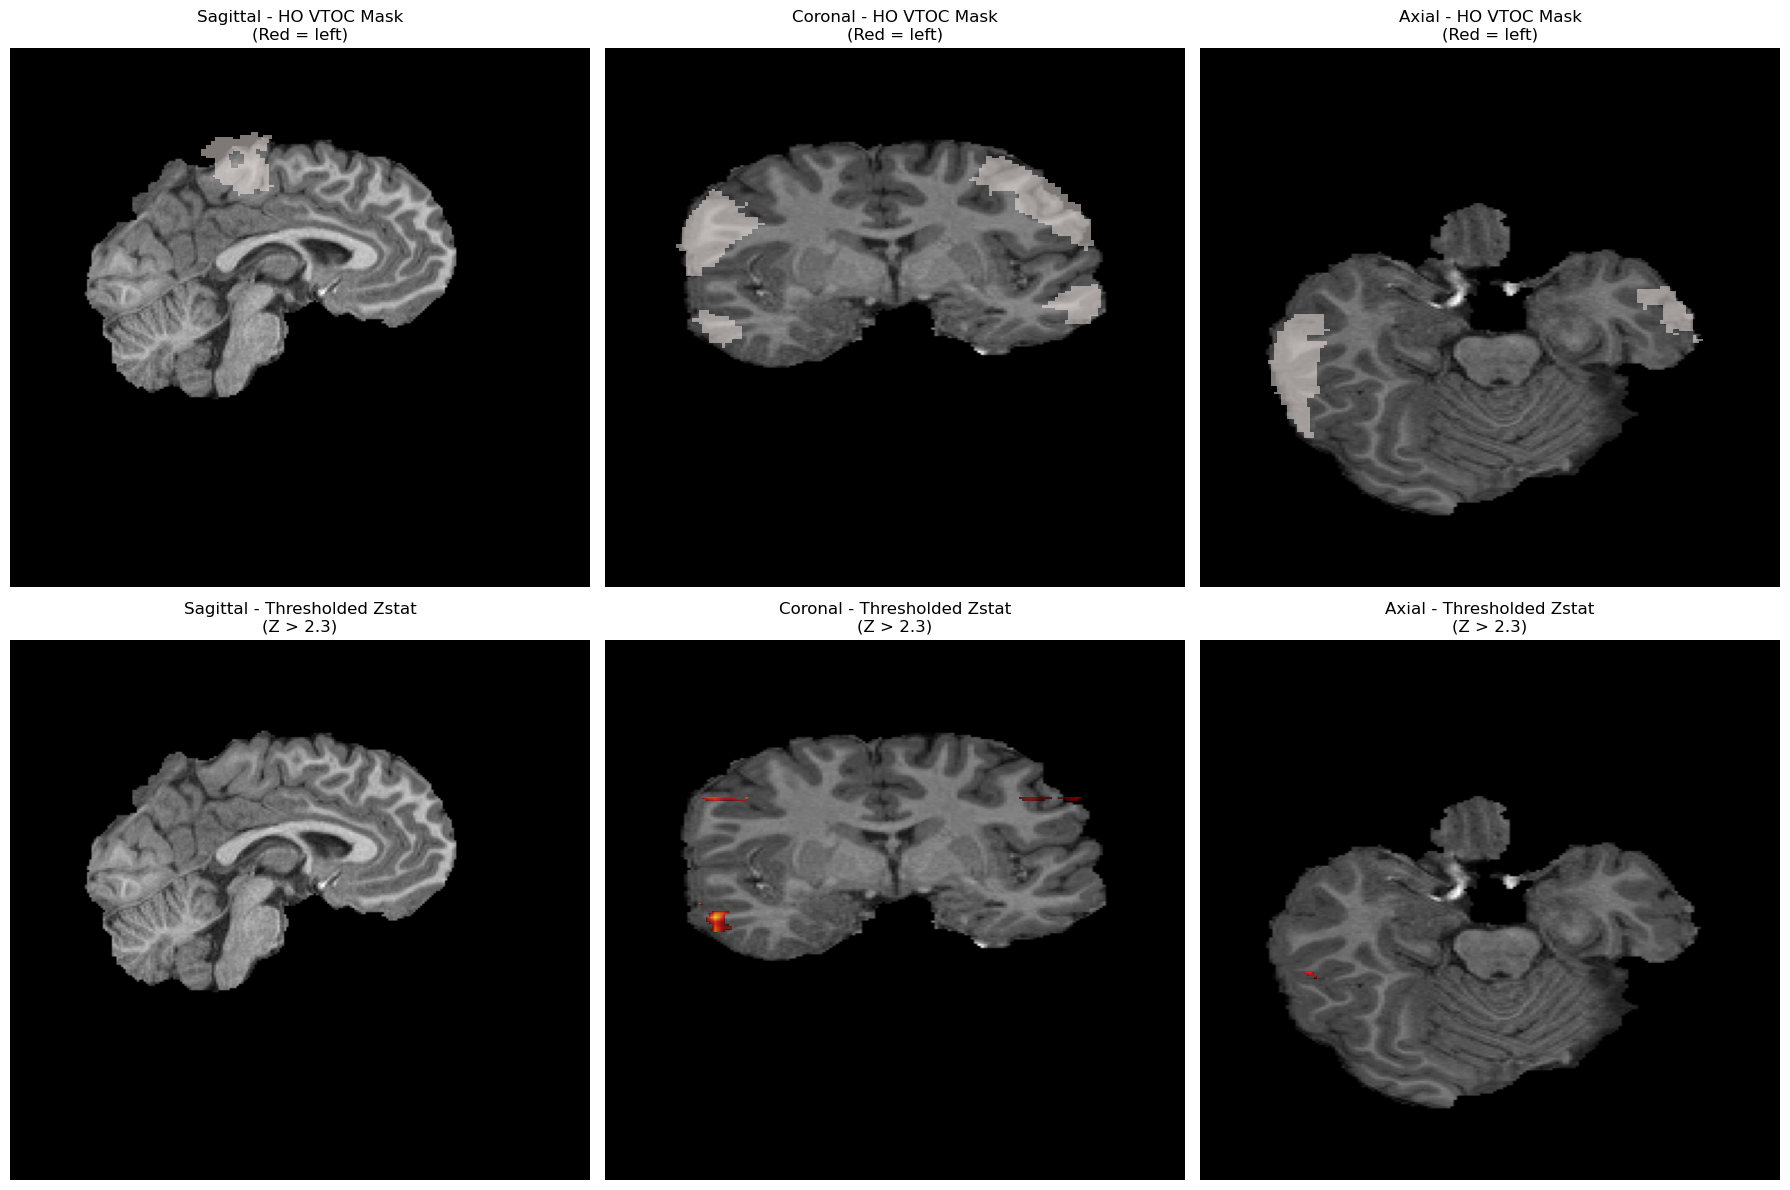


✓ Check visualizations to identify the problem


In [38]:
# NEW DIAGNOSTIC CELL: Check what's actually happening with the mask
"""
Comprehensive diagnostic of Harvard-Oxford mask and peak finding
"""

print("="*70)
print("DIAGNOSTIC: Harvard-Oxford Mask & Peak Finding")
print("="*70)

# Load data
test_subject = 'sub-004'
test_hemisphere = 'left'
test_cope = 6

anat_path = BASE_DIR / test_subject / SESSION / 'anat' / f'{test_subject}_{SESSION}_T1w_brain.nii.gz'
anat_img = nib.load(anat_path)
anat_data = anat_img.get_fdata()

# Create mask
vtoc_mask, atlas_data, vtoc_labels = create_ho_vtoc_mask(test_subject, test_hemisphere, SESSION)

print(f"\n1. MASK CHECK:")
print(f"   Requested hemisphere: {test_hemisphere}")
print(f"   Mask voxels: {vtoc_mask.sum():,}")

# Check mask location in X coordinate
affine = anat_img.affine
shape = anat_img.shape

i, j, k = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
coords = np.stack([i.ravel(), j.ravel(), k.ravel(), np.ones(i.size)])
mm_coords = affine @ coords
X = mm_coords[0].reshape(shape)

# Check X coordinates of mask voxels
mask_x_coords = X[vtoc_mask > 0]
print(f"   Mask X range: {mask_x_coords.min():.1f} to {mask_x_coords.max():.1f} mm")
print(f"   Expected for LEFT: negative values (X < -5)")
print(f"   Expected for RIGHT: positive values (X > 5)")

if test_hemisphere == 'left' and mask_x_coords.max() > 0:
    print(f"   ❌ ERROR: Mask extends into RIGHT hemisphere!")
elif test_hemisphere == 'right' and mask_x_coords.min() < 0:
    print(f"   ❌ ERROR: Mask extends into LEFT hemisphere!")
else:
    print(f"   ✓ Mask is in correct hemisphere")

# Load one run's zstat
print(f"\n2. ZSTAT CHECK:")
zstat_img = load_zstat(test_subject, SESSION, '01', test_cope)
zstat_data = zstat_img.get_fdata()

print(f"   Zstat shape: {zstat_data.shape}")
print(f"   Anat shape: {anat_data.shape}")
print(f"   Mask shape: {vtoc_mask.shape}")
print(f"   Shapes match: {zstat_data.shape == anat_data.shape == vtoc_mask.shape}")

# Check thresholded voxels
masked_zstat = zstat_data * vtoc_mask
thresholded = masked_zstat > Z_THRESHOLD
print(f"\n3. THRESHOLDING:")
print(f"   Voxels above Z={Z_THRESHOLD}: {thresholded.sum()}")

if thresholded.sum() > 0:
    # Find clusters
    labeled, num_clusters = ndimage.label(thresholded)
    print(f"   Number of clusters: {num_clusters}")
    
    if num_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, num_clusters + 1)]
        largest_cluster_label = np.argmax(cluster_sizes) + 1
        largest_cluster_mask = (labeled == largest_cluster_label)
        
        # Find peak
        cluster_zstats = masked_zstat * largest_cluster_mask
        peak_voxel = np.unravel_index(np.argmax(cluster_zstats), cluster_zstats.shape)
        peak_mm = voxel_to_mm(peak_voxel, affine)
        
        print(f"   Largest cluster: {cluster_sizes[largest_cluster_label-1]} voxels")
        print(f"   Peak voxel: {peak_voxel}")
        print(f"   Peak mm: ({peak_mm[0]:.1f}, {peak_mm[1]:.1f}, {peak_mm[2]:.1f})")
        print(f"   Peak X hemisphere: {'LEFT' if peak_mm[0] < 0 else 'RIGHT'}")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

mid_x = shape[0] // 2
mid_y = shape[1] // 2
mid_z = shape[2] // 2

# Row 1: Show mask on anatomy
for ax_idx, (slice_idx, dim, title) in enumerate([(mid_x, 0, 'Sagittal'), (mid_y, 1, 'Coronal'), (mid_z, 2, 'Axial')]):
    ax = axes[0, ax_idx]
    
    if dim == 0:
        anat_slice = anat_data[slice_idx, :, :].T
        mask_slice = vtoc_mask[slice_idx, :, :].T
    elif dim == 1:
        anat_slice = anat_data[:, slice_idx, :].T
        mask_slice = vtoc_mask[:, slice_idx, :].T
    else:
        anat_slice = anat_data[:, :, slice_idx].T
        mask_slice = vtoc_mask[:, :, slice_idx].T
    
    ax.imshow(anat_slice, cmap='gray', origin='lower', aspect='auto')
    ax.imshow(np.ma.masked_equal(mask_slice, 0), cmap='Reds', alpha=0.5, origin='lower', aspect='auto')
    ax.set_title(f'{title} - HO VTOC Mask\n(Red = {test_hemisphere})')
    ax.axis('off')

# Row 2: Show thresholded zstat
for ax_idx, (slice_idx, dim, title) in enumerate([(mid_x, 0, 'Sagittal'), (mid_y, 1, 'Coronal'), (mid_z, 2, 'Axial')]):
    ax = axes[1, ax_idx]
    
    if dim == 0:
        anat_slice = anat_data[slice_idx, :, :].T
        zstat_slice = masked_zstat[slice_idx, :, :].T
    elif dim == 1:
        anat_slice = anat_data[:, slice_idx, :].T
        zstat_slice = masked_zstat[:, slice_idx, :].T
    else:
        anat_slice = anat_data[:, :, slice_idx].T
        zstat_slice = masked_zstat[:, :, slice_idx].T
    
    ax.imshow(anat_slice, cmap='gray', origin='lower', aspect='auto')
    zstat_masked = np.ma.masked_where(zstat_slice < Z_THRESHOLD, zstat_slice)
    ax.imshow(zstat_masked, cmap='hot', alpha=0.7, origin='lower', aspect='auto', vmin=Z_THRESHOLD, vmax=5)
    ax.set_title(f'{title} - Thresholded Zstat\n(Z > {Z_THRESHOLD})')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Check visualizations to identify the problem")

In [35]:
# CELL 4: Define LOO Helper Functions (CORRECTED)
"""
Core functions for Leave-One-Out ROI definition
"""

def get_available_runs(subject, session=SESSION):
    """Get list of available first-level runs for a session"""
    loc_dir = BASE_DIR / subject / session / 'derivatives' / 'fsl' / 'loc'
    runs = sorted([d.name for d in loc_dir.iterdir() if d.name.startswith('run-') and d.is_dir()])
    run_nums = [r.split('-')[1] for r in runs]
    return run_nums

def load_zstat(subject, session, run, cope):
    """
    Load zstat from first-level analysis - REGISTERED TO SES-01 ANATOMICAL SPACE
    
    The zstats are registered by 07_register_zstats.py to:
    {run_dir}/reg_standard/stats/zstat{cope}.nii.gz
    """
    # Registered zstat location (in ses-01 anatomical space)
    zstat_path = (BASE_DIR / subject / session / 'derivatives' / 'fsl' / 'loc' / 
                  f'run-{run}' / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope}.nii.gz')
    
    if not zstat_path.exists():
        raise FileNotFoundError(
            f"Registered zstat not found at: {zstat_path}\n"
            f"Make sure 07_register_zstats.py was run for {subject} {session}"
        )
    
    return nib.load(zstat_path)


def find_peak_in_largest_cluster(zstat_data, vtoc_mask, z_threshold=Z_THRESHOLD):
    """
    Find peak voxel in largest cluster above threshold within VTOC
    
    Returns:
    --------
    peak_coords_mm : tuple (x, y, z) in mm, or None if no clusters found
    peak_z_value : float, or None
    cluster_size : int, or None
    """
    # Apply VTOC mask and threshold
    masked_zstat = zstat_data * vtoc_mask
    thresholded = masked_zstat > z_threshold
    
    # Find connected components (clusters)
    labeled, num_clusters = ndimage.label(thresholded)
    
    if num_clusters == 0:
        return None, None, None
    
    # Find largest cluster
    cluster_sizes = [(labeled == i).sum() for i in range(1, num_clusters + 1)]
    largest_cluster_label = np.argmax(cluster_sizes) + 1
    largest_cluster_mask = (labeled == largest_cluster_label)
    
    # Find peak within largest cluster
    cluster_zstats = masked_zstat * largest_cluster_mask
    peak_voxel_idx = np.unravel_index(np.argmax(cluster_zstats), cluster_zstats.shape)
    peak_z_value = cluster_zstats[peak_voxel_idx]
    
    return peak_voxel_idx, peak_z_value, cluster_sizes[largest_cluster_label - 1]


def voxel_to_mm(voxel_coords, affine):
    """Convert voxel coordinates to mm using affine"""
    voxel_homogeneous = np.array([*voxel_coords, 1])
    mm_coords = affine @ voxel_homogeneous
    return tuple(mm_coords[:3])


def create_sphere_roi(center_mm, radius_mm, reference_img):
    """
    Create spherical ROI mask
    
    Parameters:
    -----------
    center_mm : tuple (x, y, z)
        Center coordinates in mm
    radius_mm : float
        Sphere radius in mm
    reference_img : nibabel image
        Reference image for affine and shape
    
    Returns:
    --------
    sphere_mask : nibabel image
        Binary sphere mask
    """
    affine = reference_img.affine
    shape = reference_img.shape
    
    # Create coordinate grids
    i, j, k = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        indexing='ij'
    )
    
    # Convert to mm
    coords = np.stack([i.ravel(), j.ravel(), k.ravel(), np.ones(i.size)])
    mm_coords = affine @ coords
    X = mm_coords[0].reshape(shape)
    Y = mm_coords[1].reshape(shape)
    Z = mm_coords[2].reshape(shape)
    
    # Calculate distance from center
    distance = np.sqrt(
        (X - center_mm[0])**2 + 
        (Y - center_mm[1])**2 + 
        (Z - center_mm[2])**2
    )
    
    # Create sphere
    sphere_mask = (distance <= radius_mm).astype(np.uint8)
    
    return nib.Nifti1Image(sphere_mask, affine)


print("✓ Helper functions defined:")
print("  - get_available_runs()")
print("  - load_zstat() [LOADS REGISTERED ZSTATS IN ANATOMICAL SPACE]")
print("  - find_peak_in_largest_cluster()")
print("  - voxel_to_mm()")
print("  - create_sphere_roi()")

✓ Helper functions defined:
  - get_available_runs()
  - load_zstat() [LOADS REGISTERED ZSTATS IN ANATOMICAL SPACE]
  - find_peak_in_largest_cluster()
  - voxel_to_mm()
  - create_sphere_roi()


In [34]:
# CELL 5: Test LOO on Single ROI (sub-004, left FFA) - UPDATED
"""
Test the LOO procedure on a single ROI using Harvard-Oxford atlas mask
"""

test_subject = 'sub-004'
test_hemisphere = 'left'
test_roi = 'FFA'
test_cope = ROI_CONFIG[test_roi]['cope']

print(f"Testing LOO for {test_subject} - {test_hemisphere} {test_roi} (cope{test_cope})")
print("="*70)

# Get available runs
runs = get_available_runs(test_subject, SESSION)
n_runs = len(runs)
print(f"\nFound {n_runs} runs in {SESSION}: {runs}")

# Load anatomical and create Harvard-Oxford VTOC mask
anat_path = BASE_DIR / test_subject / SESSION / 'anat' / f'{test_subject}_{SESSION}_T1w_brain.nii.gz'
anat_img = nib.load(anat_path)
vtoc_mask, atlas_data, vtoc_labels = create_ho_vtoc_mask(test_subject, test_hemisphere, SESSION)

print(f"\nUsing Harvard-Oxford VTOC mask:")
print(f"  Hemisphere: {test_hemisphere}")
print(f"  Mask size: {vtoc_mask.sum():,} voxels")
print(f"  Regions: {len(vtoc_labels)}")

# LOO iterations
loo_peaks = []

for left_out_idx, left_out_run in enumerate(runs):
    print(f"\n--- LOO Iteration {left_out_idx + 1}/{n_runs} (leaving out run-{left_out_run}) ---")
    
    # Get other runs
    other_runs = [r for r in runs if r != left_out_run]
    print(f"Using runs: {other_runs}")
    
    # Load and average zstats from other runs
    zstats = []
    for run in other_runs:
        zstat_img = load_zstat(test_subject, SESSION, run, test_cope)
        zstats.append(zstat_img.get_fdata())
    
    # Average across runs
    mean_zstat = np.mean(zstats, axis=0)
    print(f"Mean zstat range: {mean_zstat[vtoc_mask > 0].min():.2f} to {mean_zstat[vtoc_mask > 0].max():.2f}")
    
    # Find peak
    peak_voxel, peak_z, cluster_size = find_peak_in_largest_cluster(mean_zstat, vtoc_mask, Z_THRESHOLD)
    
    if peak_voxel is None:
        print(f"  ⚠️ WARNING: No clusters found above Z={Z_THRESHOLD}")
        continue
    
    # Convert to mm
    peak_mm = voxel_to_mm(peak_voxel, anat_img.affine)
    
    # Store results
    loo_peaks.append({
        'left_out_run': left_out_run,
        'peak_voxel': peak_voxel,
        'peak_mm': peak_mm,
        'peak_z': peak_z,
        'cluster_size': cluster_size
    })
    
    print(f"  Peak voxel: {peak_voxel}")
    print(f"  Peak (mm): ({peak_mm[0]:.1f}, {peak_mm[1]:.1f}, {peak_mm[2]:.1f})")
    print(f"  Peak Z: {peak_z:.2f}")
    print(f"  Cluster size: {cluster_size} voxels")

# Calculate averaged final coordinate
if len(loo_peaks) > 0:
    final_coords = np.mean([p['peak_mm'] for p in loo_peaks], axis=0)
    coord_std = np.std([p['peak_mm'] for p in loo_peaks], axis=0)
    mean_z = np.mean([p['peak_z'] for p in loo_peaks])
    
    print(f"\n{'='*70}")
    print(f"FINAL AVERAGED COORDINATES:")
    print(f"  X: {final_coords[0]:.1f} mm (±{coord_std[0]:.1f})")
    print(f"  Y: {final_coords[1]:.1f} mm (±{coord_std[1]:.1f})")
    print(f"  Z: {final_coords[2]:.1f} mm (±{coord_std[2]:.1f})")
    print(f"  Mean Z-value: {mean_z:.2f}")
    print(f"  N iterations: {len(loo_peaks)}/{n_runs}")
    
    # Check variability
    max_variability = np.max(coord_std)
    if max_variability < 5:
        print(f"  ✓ Coordinate variability: {max_variability:.1f} mm (Good - under 5mm)")
    else:
        print(f"  ⚠️ Coordinate variability: {max_variability:.1f} mm (High - check activation maps)")
else:
    print("\n❌ ERROR: No peaks found in any LOO iteration!")

print(f"\n✓ VERIFY: Coordinates are consistent (~2-5mm variability)")

Testing LOO for sub-004 - left FFA (cope6)

Found 3 runs in ses-01: ['01', '02', '03']

Using Harvard-Oxford VTOC mask:
  Hemisphere: left
  Mask size: 167,035 voxels
  Regions: 9

--- LOO Iteration 1/3 (leaving out run-01) ---
Using runs: ['02', '03']
Mean zstat range: -2.81 to 2.51
  Peak voxel: (131, 154, 176)
  Peak (mm): (47.5, 27.0, 49.0)
  Peak Z: 2.51
  Cluster size: 8 voxels

--- LOO Iteration 2/3 (leaving out run-02) ---
Using runs: ['01', '03']
Mean zstat range: -3.13 to 2.93
  Peak voxel: (142, 129, 181)
  Peak (mm): (58.5, 2.0, 54.0)
  Peak Z: 2.66
  Cluster size: 318 voxels

--- LOO Iteration 3/3 (leaving out run-03) ---
Using runs: ['01', '02']
Mean zstat range: -4.00 to 3.44
  Peak voxel: (26, 126, 132)
  Peak (mm): (-57.5, -1.0, 5.0)
  Peak Z: 3.44
  Cluster size: 40 voxels

FINAL AVERAGED COORDINATES:
  X: 16.2 mm (±52.3)
  Y: 9.3 mm (±12.6)
  Z: 36.0 mm (±22.0)
  Mean Z-value: 2.87
  N iterations: 3/3
  ⚠️ Coordinate variability: 52.3 mm (High - check activation maps

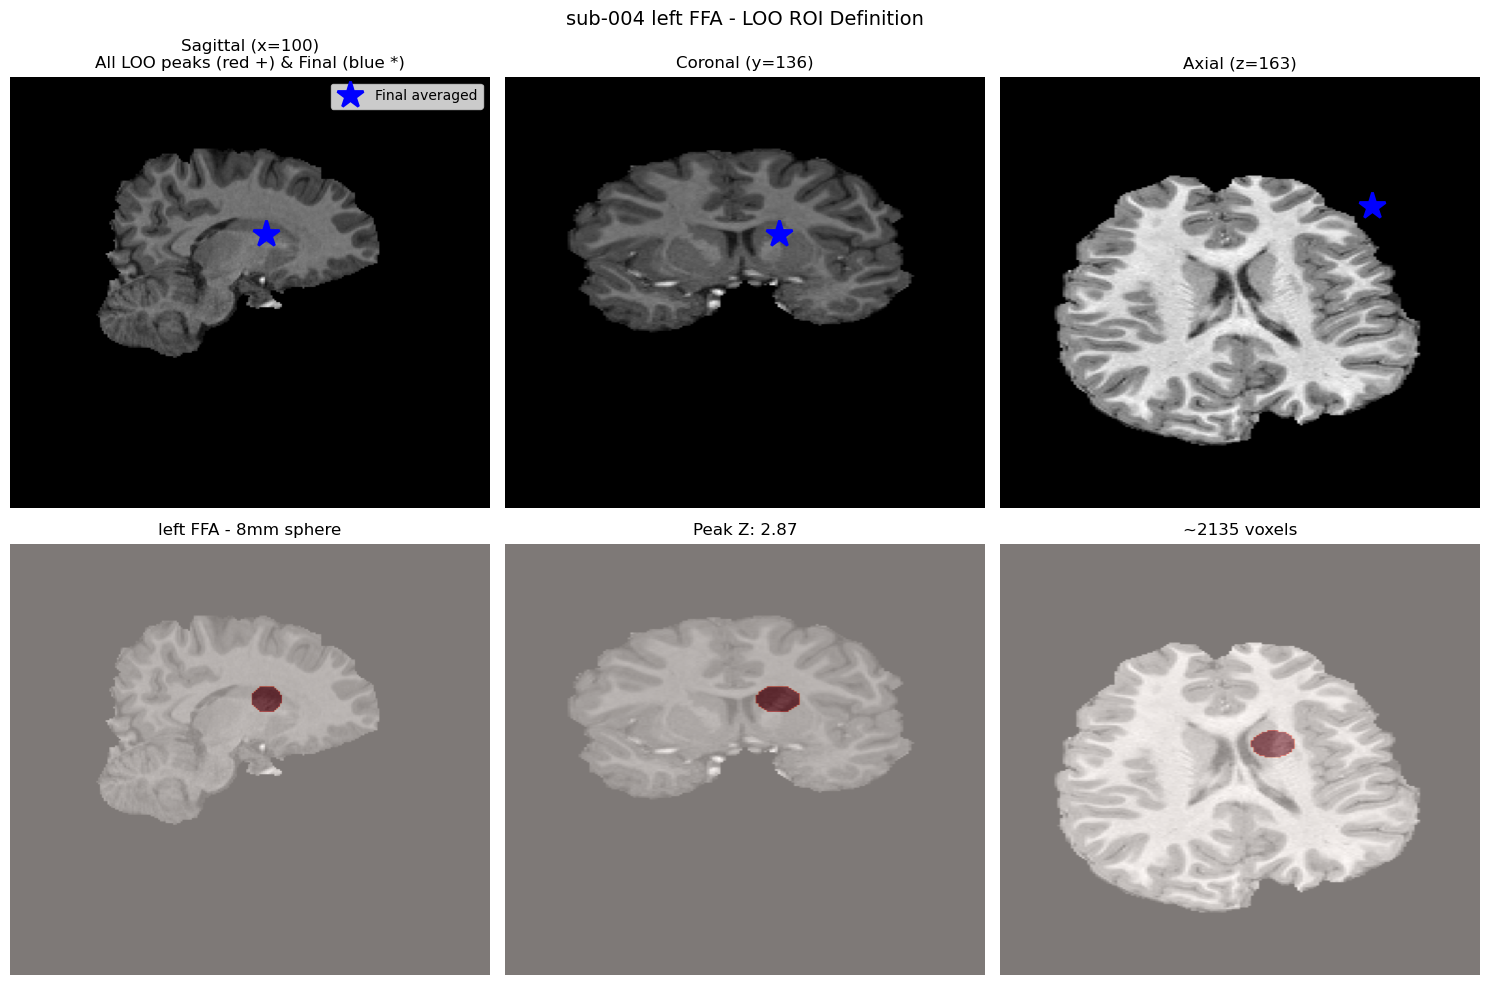


✓ VERIFY: Location makes anatomical sense for Fusiform gyrus


In [36]:
# CELL 6: Visualize Test ROI
"""
Visualize the LOO peaks and final averaged ROI on anatomy
"""

if len(loo_peaks) > 0:
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Load anatomical
    anat_data = anat_img.get_fdata()
    
    # Get final averaged coordinate
    final_coords = np.mean([p['peak_mm'] for p in loo_peaks], axis=0)
    
    # Convert final coords back to voxel space for visualization
    final_voxel = np.round(np.linalg.inv(anat_img.affine) @ np.array([*final_coords, 1]))[:3].astype(int)
    
    # Create sphere at 8mm for visualization
    sphere_8mm = create_sphere_roi(final_coords, 8, anat_img)
    sphere_data = sphere_8mm.get_fdata()
    
    # Get slices through peak
    x, y, z = final_voxel
    
    # Row 1: Show all LOO peaks
    # Sagittal
    ax = axes[0, 0]
    ax.imshow(np.rot90(anat_data[x, :, :]), cmap='gray', aspect='auto')
    for peak_info in loo_peaks:
        peak_vox = peak_info['peak_voxel']
        if abs(peak_vox[0] - x) < 3:  # Within 3 voxels of slice
            ax.plot(peak_vox[1], anat_data.shape[2] - peak_vox[2], 'r+', markersize=15, markeredgewidth=2)
    ax.plot(y, anat_data.shape[2] - z, 'b*', markersize=20, markeredgewidth=2, label='Final averaged')
    ax.set_title(f'Sagittal (x={x})\nAll LOO peaks (red +) & Final (blue *)')
    ax.legend()
    ax.axis('off')
    
    # Coronal
    ax = axes[0, 1]
    ax.imshow(np.rot90(anat_data[:, y, :]), cmap='gray', aspect='auto')
    for peak_info in loo_peaks:
        peak_vox = peak_info['peak_voxel']
        if abs(peak_vox[1] - y) < 3:
            ax.plot(peak_vox[0], anat_data.shape[2] - peak_vox[2], 'r+', markersize=15, markeredgewidth=2)
    ax.plot(x, anat_data.shape[2] - z, 'b*', markersize=20, markeredgewidth=2)
    ax.set_title(f'Coronal (y={y})')
    ax.axis('off')
    
    # Axial
    ax = axes[0, 2]
    ax.imshow(np.rot90(anat_data[:, :, z]), cmap='gray', aspect='auto')
    for peak_info in loo_peaks:
        peak_voxel = peak_info['peak_voxel']
        if abs(peak_vox[2] - z) < 3:
            ax.plot(peak_vox[1], anat_data.shape[0] - peak_vox[0], 'r+', markersize=15, markeredgewidth=2)
    ax.plot(y, anat_data.shape[0] - x, 'b*', markersize=20, markeredgewidth=2)
    ax.set_title(f'Axial (z={z})')
    ax.axis('off')
    
    # Row 2: Show final 8mm sphere
    # Sagittal
    ax = axes[1, 0]
    ax.imshow(np.rot90(anat_data[x, :, :]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(sphere_data[x, :, :]), cmap='Reds', alpha=0.5, aspect='auto')
    ax.set_title(f'{test_hemisphere} {test_roi} - 8mm sphere')
    ax.axis('off')
    
    # Coronal
    ax = axes[1, 1]
    ax.imshow(np.rot90(anat_data[:, y, :]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(sphere_data[:, y, :]), cmap='Reds', alpha=0.5, aspect='auto')
    ax.set_title(f'Peak Z: {mean_z:.2f}')
    ax.axis('off')
    
    # Axial
    ax = axes[1, 2]
    ax.imshow(np.rot90(anat_data[:, :, z]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(sphere_data[:, :, z]), cmap='Reds', alpha=0.5, aspect='auto')
    ax.set_title(f'~{int(sphere_data.sum())} voxels')
    ax.axis('off')
    
    plt.suptitle(f'{test_subject} {test_hemisphere} {test_roi} - LOO ROI Definition', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ VERIFY: Location makes anatomical sense for {ROI_CONFIG[test_roi]['anatomical_target']}")
else:
    print("Cannot visualize - no peaks found")


--- LOO Iteration 1 ---
Left out: run-01
Peak voxel (i,j,k): (131, 154, 176)
Peak mm (x,y,z): (47.5, 27.0, 49.0)
Number of clusters: 10
Largest cluster: 38 voxels

--- LOO Iteration 2 ---
Left out: run-02
Peak voxel (i,j,k): (142, 129, 181)
Peak mm (x,y,z): (58.5, 2.0, 54.0)
Number of clusters: 20
Largest cluster: 322 voxels

--- LOO Iteration 3 ---
Left out: run-03
Peak voxel (i,j,k): (26, 126, 132)
Peak mm (x,y,z): (-57.5, -1.0, 5.0)
Number of clusters: 31
Largest cluster: 544 voxels


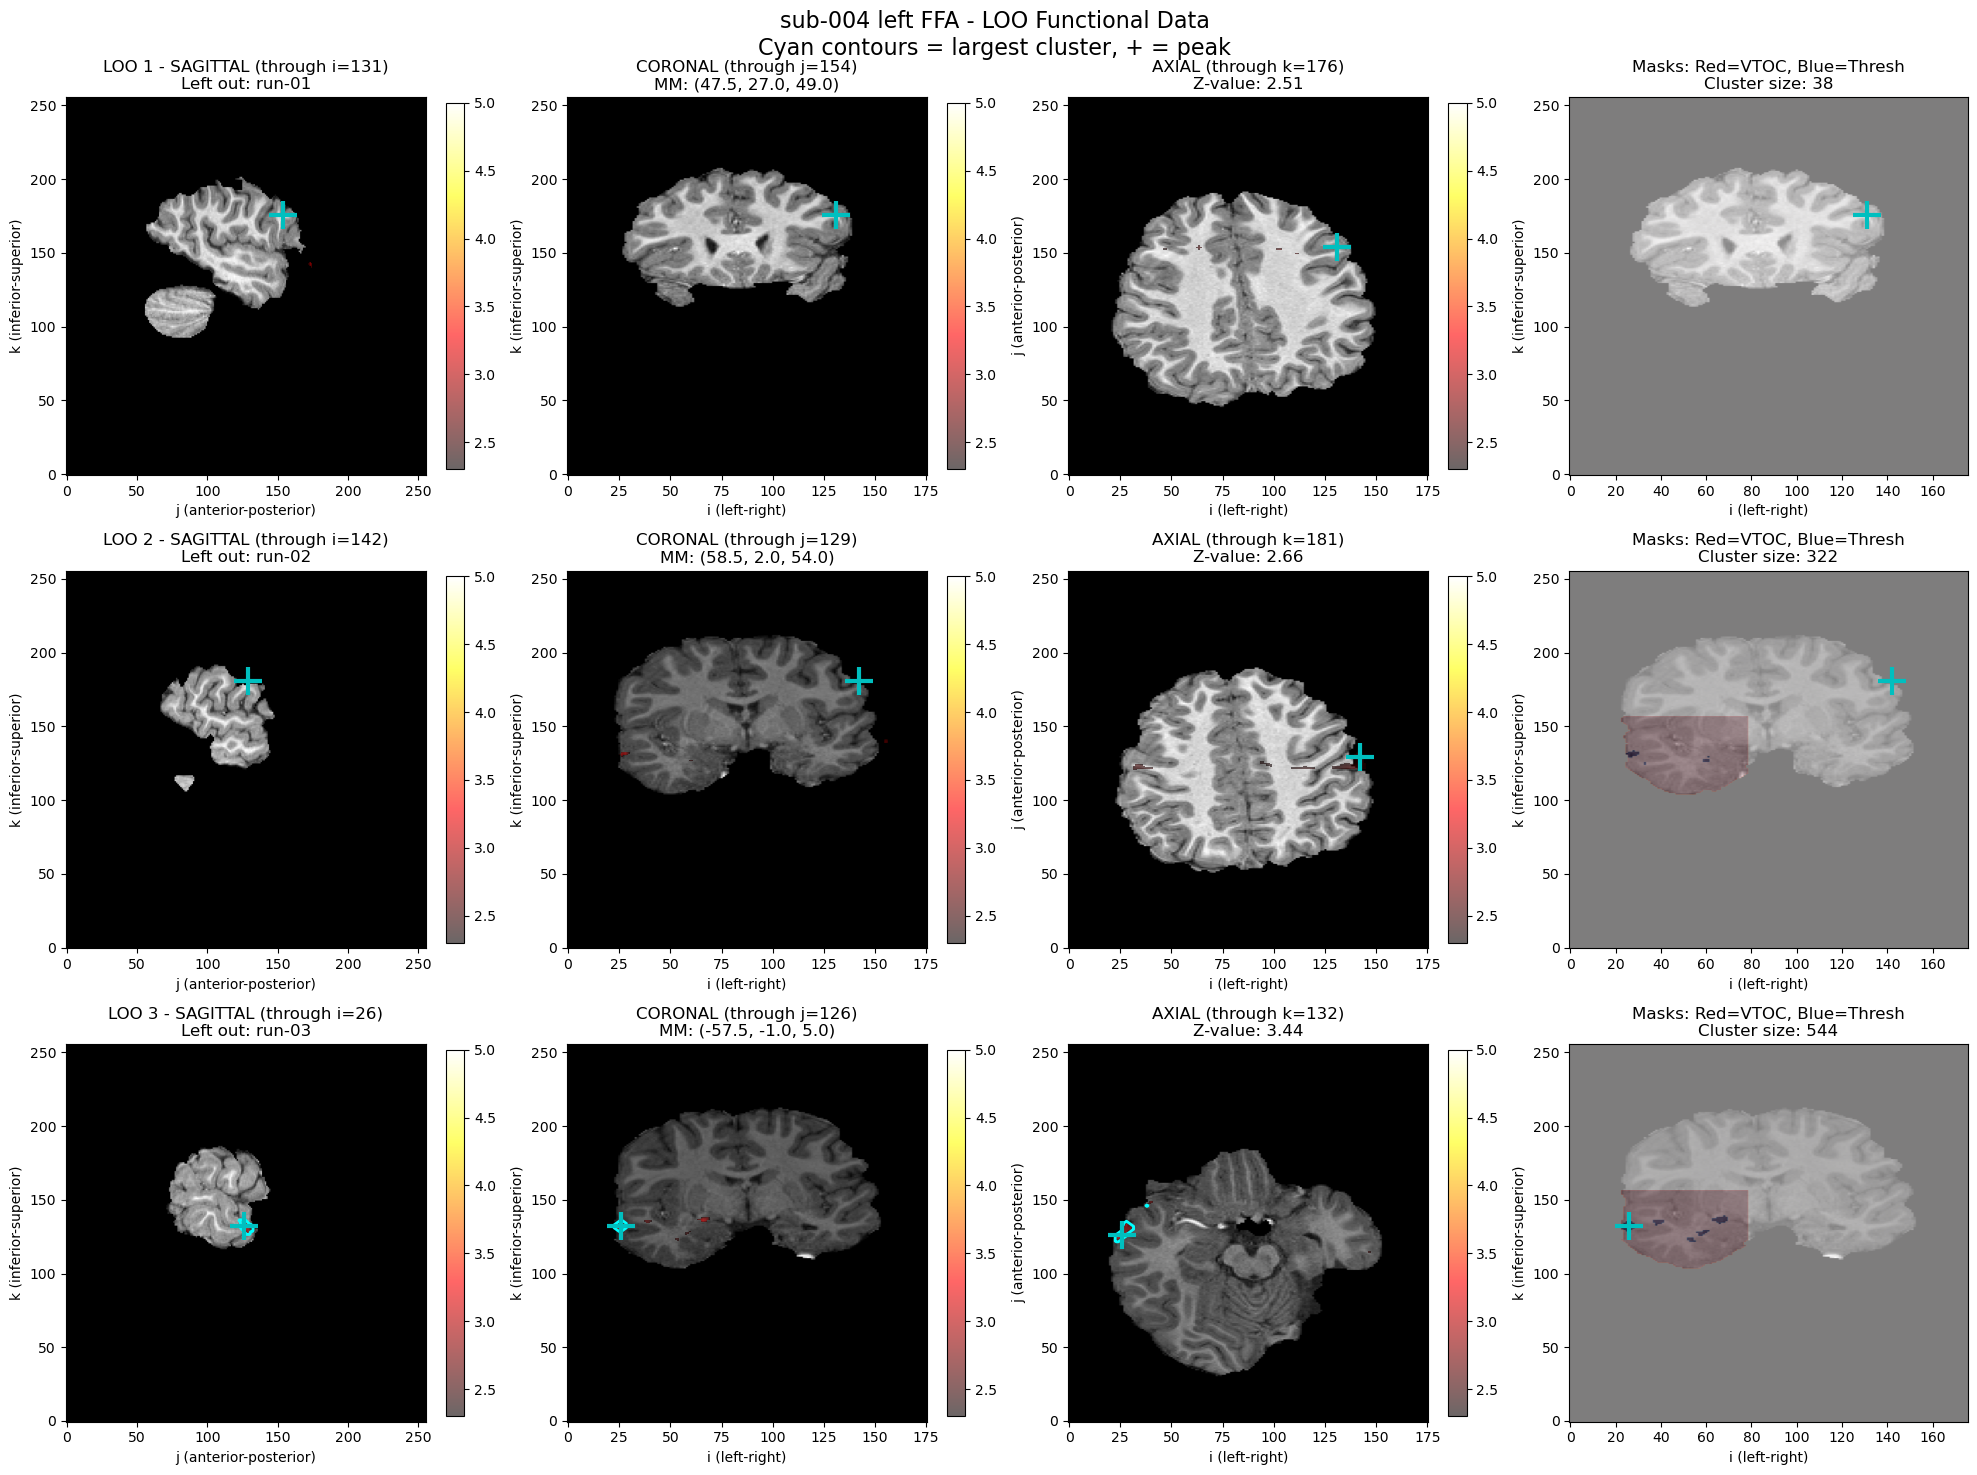


HEMISPHERE CONSISTENCY CHECK:
❌ LOO 1: voxel i=131, mm x=  47.5 (expected left = negative)
❌ LOO 2: voxel i=142, mm x=  58.5 (expected left = negative)
✓ LOO 3: voxel i= 26, mm x= -57.5 (expected left = negative)


In [37]:
# REPLACE CELL 5.5 with this corrected version:
"""
Diagnostic visualization of functional data with CORRECT coordinate handling
"""

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Reload anatomical and VTOC mask
anat_data = anat_img.get_fdata()
vtoc_mask = create_vtoc_mask(anat_img, test_hemisphere)

for loo_idx, peak_info in enumerate(loo_peaks):
    print(f"\n--- LOO Iteration {loo_idx + 1} ---")
    
    # Reload the averaged zstat for this iteration
    left_out_run = peak_info['left_out_run']
    other_runs = [r for r in runs if r != left_out_run]
    
    # Load and average
    zstats = []
    for run in other_runs:
        zstat_img = load_zstat(test_subject, SESSION, run, test_cope)
        zstats.append(zstat_img.get_fdata())
    mean_zstat = np.mean(zstats, axis=0)
    
    # Get peak location
    peak_vox = peak_info['peak_voxel']
    x, y, z = peak_vox
    
    # Create masked zstat and find clusters
    masked_zstat = mean_zstat * vtoc_mask
    thresholded = (masked_zstat > Z_THRESHOLD).astype(int)
    
    # Find the largest cluster for this iteration
    from scipy.ndimage import label
    labeled, num_clusters = label(thresholded)
    if num_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, num_clusters + 1)]
        largest_cluster_label = np.argmax(cluster_sizes) + 1
        largest_cluster_mask = (labeled == largest_cluster_label)
    else:
        largest_cluster_mask = np.zeros_like(thresholded)
    
    print(f"Left out: run-{left_out_run}")
    print(f"Peak voxel (i,j,k): ({x}, {y}, {z})")
    print(f"Peak mm (x,y,z): ({peak_info['peak_mm'][0]:.1f}, {peak_info['peak_mm'][1]:.1f}, {peak_info['peak_mm'][2]:.1f})")
    print(f"Number of clusters: {num_clusters}")
    print(f"Largest cluster: {cluster_sizes[largest_cluster_label-1] if num_clusters > 0 else 0} voxels")
    
    # Sagittal view - slice through X dimension (LEFT-RIGHT)
    ax = axes[loo_idx, 0]
    ax.imshow(anat_data[x, :, :].T, cmap='gray', origin='lower', aspect='auto')
    # Show thresholded activation
    zstat_slice = mean_zstat[x, :, :].T
    zstat_masked = np.ma.masked_where(zstat_slice < Z_THRESHOLD, zstat_slice)
    im = ax.imshow(zstat_masked, cmap='hot', alpha=0.6, origin='lower', aspect='auto', vmin=Z_THRESHOLD, vmax=5)
    # Show cluster
    cluster_slice = largest_cluster_mask[x, :, :].T
    ax.contour(cluster_slice, colors='cyan', linewidths=2, levels=[0.5])
    # Mark peak
    ax.plot(y, z, 'c+', markersize=20, markeredgewidth=3)
    ax.set_title(f'LOO {loo_idx+1} - SAGITTAL (through i={x})\nLeft out: run-{left_out_run}')
    ax.set_xlabel('j (anterior-posterior)')
    ax.set_ylabel('k (inferior-superior)')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Coronal view - slice through Y dimension (ANTERIOR-POSTERIOR)
    ax = axes[loo_idx, 1]
    ax.imshow(anat_data[:, y, :].T, cmap='gray', origin='lower', aspect='auto')
    zstat_slice = mean_zstat[:, y, :].T
    zstat_masked = np.ma.masked_where(zstat_slice < Z_THRESHOLD, zstat_slice)
    im = ax.imshow(zstat_masked, cmap='hot', alpha=0.6, origin='lower', aspect='auto', vmin=Z_THRESHOLD, vmax=5)
    cluster_slice = largest_cluster_mask[:, y, :].T
    ax.contour(cluster_slice, colors='cyan', linewidths=2, levels=[0.5])
    ax.plot(x, z, 'c+', markersize=20, markeredgewidth=3)
    ax.set_title(f'CORONAL (through j={y})\nMM: ({peak_info["peak_mm"][0]:.1f}, {peak_info["peak_mm"][1]:.1f}, {peak_info["peak_mm"][2]:.1f})')
    ax.set_xlabel('i (left-right)')
    ax.set_ylabel('k (inferior-superior)')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Axial view - slice through Z dimension (INFERIOR-SUPERIOR)
    ax = axes[loo_idx, 2]
    ax.imshow(anat_data[:, :, z].T, cmap='gray', origin='lower', aspect='auto')
    zstat_slice = mean_zstat[:, :, z].T
    zstat_masked = np.ma.masked_where(zstat_slice < Z_THRESHOLD, zstat_slice)
    im = ax.imshow(zstat_masked, cmap='hot', alpha=0.6, origin='lower', aspect='auto', vmin=Z_THRESHOLD, vmax=5)
    cluster_slice = largest_cluster_mask[:, :, z].T
    ax.contour(cluster_slice, colors='cyan', linewidths=2, levels=[0.5])
    ax.plot(x, y, 'c+', markersize=20, markeredgewidth=3)
    ax.set_title(f'AXIAL (through k={z})\nZ-value: {peak_info["peak_z"]:.2f}')
    ax.set_xlabel('i (left-right)')
    ax.set_ylabel('j (anterior-posterior)')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # VTOC mask view (coronal through peak)
    ax = axes[loo_idx, 3]
    ax.imshow(anat_data[:, y, :].T, cmap='gray', origin='lower', aspect='auto')
    vtoc_slice = vtoc_mask[:, y, :].T
    ax.imshow(vtoc_slice, cmap='Reds', alpha=0.3, origin='lower', aspect='auto')
    thresh_slice = thresholded[:, y, :].T
    ax.imshow(thresh_slice, cmap='Blues', alpha=0.3, origin='lower', aspect='auto')
    ax.plot(x, z, 'c+', markersize=20, markeredgewidth=3)
    ax.set_title(f'Masks: Red=VTOC, Blue=Thresh\nCluster size: {cluster_sizes[largest_cluster_label-1] if num_clusters > 0 else 0}')
    ax.set_xlabel('i (left-right)')
    ax.set_ylabel('k (inferior-superior)')

plt.suptitle(f'{test_subject} {test_hemisphere} {test_roi} - LOO Functional Data\nCyan contours = largest cluster, + = peak', fontsize=16)
plt.tight_layout()
plt.show()

# Verify hemisphere consistency
print(f"\n{'='*70}")
print(f"HEMISPHERE CONSISTENCY CHECK:")
print(f"{'='*70}")
for loo_idx, peak_info in enumerate(loo_peaks):
    peak_vox = peak_info['peak_voxel']
    peak_mm = peak_info['peak_mm']
    
    # Check if mm coordinates match expected hemisphere
    expected_sign = -1 if test_hemisphere == 'left' else 1
    actual_sign = np.sign(peak_mm[0])
    
    status = "✓" if expected_sign == actual_sign else "❌"
    print(f"{status} LOO {loo_idx+1}: voxel i={peak_vox[0]:3d}, mm x={peak_mm[0]:6.1f} (expected {test_hemisphere} = {'negative' if expected_sign < 0 else 'positive'})")

In [ ]:
# CELL 7: Run All ROIs for One Subject (sub-004)
"""
Process all 6 ROIs × 2 hemispheres for a single subject
Store results in DataFrame for review
"""

def process_subject_rois(subject, session=SESSION):
    """
    Process all ROIs for one subject
    
    Returns:
    --------
    results_df : pandas DataFrame
        Coordinates and metadata for all ROIs
    """
    print(f"\nProcessing {subject} ({SUBJECTS[subject]['patient_code']})")
    print("="*70)
    
    results = []
    
    # Load anatomical
    anat_path = BASE_DIR / subject / session / 'anat' / f'{subject}_{session}_T1w_brain.nii.gz'
    anat_img = nib.load(anat_path)
    
    # Get available runs
    runs = get_available_runs(subject, session)
    n_runs = len(runs)
    print(f"Found {n_runs} runs: {runs}\n")
    
    # Process each ROI and hemisphere
    for roi_name, roi_info in ROI_CONFIG.items():
        cope = roi_info['cope']
        
        for hemisphere in HEMISPHERES:
            print(f"\n{hemisphere} {roi_name} (cope{cope})...")
            
            # Create VTOC mask
            vtoc_mask = create_vtoc_mask(anat_img, hemisphere)
            
            # LOO iterations
            loo_peaks = []
            
            for left_out_run in runs:
                # Get other runs
                other_runs = [r for r in runs if r != left_out_run]
                
                # Load and average zstats
                try:
                    zstats = []
                    for run in other_runs:
                        zstat_img = load_zstat(subject, session, run, cope)
                        zstats.append(zstat_img.get_fdata())
                    
                    mean_zstat = np.mean(zstats, axis=0)
                    
                    # Find peak
                    peak_voxel, peak_z, cluster_size = find_peak_in_largest_cluster(
                        mean_zstat, vtoc_mask, Z_THRESHOLD
                    )
                    
                    if peak_voxel is not None:
                        peak_mm = voxel_to_mm(peak_voxel, anat_img.affine)
                        loo_peaks.append({
                            'peak_mm': peak_mm,
                            'peak_z': peak_z,
                            'cluster_size': cluster_size
                        })
                    
                except FileNotFoundError as e:
                    print(f"  ⚠️ Missing file for run-{left_out_run}: {e}")
                    continue
            
            # Calculate final averaged coordinates
            if len(loo_peaks) > 0:
                final_coords = np.mean([p['peak_mm'] for p in loo_peaks], axis=0)
                coord_std = np.std([p['peak_mm'] for p in loo_peaks], axis=0)
                mean_z = np.mean([p['peak_z'] for p in loo_peaks])
                mean_cluster_size = np.mean([p['cluster_size'] for p in loo_peaks])
                
                results.append({
                    'subject': subject,
                    'patient_code': SUBJECTS[subject]['patient_code'],
                    'hemisphere': hemisphere,
                    'roi': roi_name,
                    'cope': cope,
                    'contrast': roi_info['contrast'],
                    'x': final_coords[0],
                    'y': final_coords[1],
                    'z': final_coords[2],
                    'x_std': coord_std[0],
                    'y_std': coord_std[1],
                    'z_std': coord_std[2],
                    'mean_z_value': mean_z,
                    'mean_cluster_size': mean_cluster_size,
                    'n_loo_iterations': len(loo_peaks),
                    'max_std': np.max(coord_std)
                })
                
                print(f"  ✓ Peak: ({final_coords[0]:.1f}, {final_coords[1]:.1f}, {final_coords[2]:.1f})")
                print(f"     Z={mean_z:.2f}, variability={np.max(coord_std):.1f}mm")
            else:
                print(f"  ❌ No peaks found above Z={Z_THRESHOLD}")
                results.append({
                    'subject': subject,
                    'patient_code': SUBJECTS[subject]['patient_code'],
                    'hemisphere': hemisphere,
                    'roi': roi_name,
                    'cope': cope,
                    'contrast': roi_info['contrast'],
                    'x': np.nan,
                    'y': np.nan,
                    'z': np.nan,
                    'x_std': np.nan,
                    'y_std': np.nan,
                    'z_std': np.nan,
                    'mean_z_value': np.nan,
                    'mean_cluster_size': np.nan,
                    'n_loo_iterations': 0,
                    'max_std': np.nan
                })
    
    return pd.DataFrame(results)

# Test on sub-004
test_results = process_subject_rois('sub-004')

# Display results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

print("\n" + "="*70)
print("RESULTS FOR sub-004:")
print("="*70)
display(test_results)

# Check for issues
missing = test_results[test_results['x'].isna()]
if len(missing) > 0:
    print(f"\n⚠️ WARNING: {len(missing)} ROIs not found:")
    display(missing[['hemisphere', 'roi', 'cope']])

high_var = test_results[test_results['max_std'] > 5]
if len(high_var) > 0:
    print(f"\n⚠️ WARNING: {len(high_var)} ROIs with high coordinate variability (>5mm):")
    display(high_var[['hemisphere', 'roi', 'max_std']])

print("\n✓ VERIFY: All ROIs found and coordinates look reasonable")

In [ ]:
# CELL 8: Run All Subjects and Save Results
"""
Process all subjects and save:
1. Master coordinate CSV
2. Sphere masks (3 radii per ROI)
"""

all_results = []

for subject in SUBJECTS.keys():
    print(f"\n{'#'*70}")
    print(f"# Processing {subject}")
    print(f"{'#'*70}")
    
    # Process subject
    subject_results = process_subject_rois(subject, SESSION)
    all_results.append(subject_results)
    
    # Create ROI directory
    roi_dir = BASE_DIR / subject / SESSION / 'ROIs'
    roi_dir.mkdir(parents=True, exist_ok=True)
    
    # Load anatomical for sphere creation
    anat_path = BASE_DIR / subject / SESSION / 'anat' / f'{subject}_{SESSION}_T1w_brain.nii.gz'
    anat_img = nib.load(anat_path)
    
    # Create and save sphere masks
    for _, row in subject_results.iterrows():
        if not np.isnan(row['x']):
            center_mm = (row['x'], row['y'], row['z'])
            hemi_prefix = row['hemisphere'][0]  # 'l' or 'r'
            roi_name = row['roi']
            
            for radius in SPHERE_RADII:
                # Create sphere
                sphere_img = create_sphere_roi(center_mm, radius, anat_img)
                
                # Save
                filename = f"{hemi_prefix}_{roi_name}_loo_r{radius}mm.nii.gz"
                save_path = roi_dir / filename
                nib.save(sphere_img, save_path)
            
            print(f"  ✓ Saved {hemi_prefix}_{roi_name} (3 radii)")

# Combine all results
master_df = pd.concat(all_results, ignore_index=True)

# Save master coordinate table
csv_path = BASE_DIR / 'ROI_coordinates_ses01_loo.csv'
master_df.to_csv(csv_path, index=False)
print(f"\n✓ Saved master coordinates: {csv_path}")

# Display summary
print("\n" + "="*70)
print("MASTER ROI COORDINATE TABLE:")
print("="*70)
display(master_df)

# File count
total_rois = len(master_df[~master_df['x'].isna()])
total_files = total_rois * len(SPHERE_RADII)
print(f"\n✓ Created {total_files} sphere mask files ({total_rois} ROIs × {len(SPHERE_RADII)} radii)")
print(f"✓ VERIFY: File structure correct in /sub-XXX/ses-01/ROIs/")

In [ ]:
# CELL 9: Summary Visualization
"""
Show all ROIs overlaid on each subject's brain
"""

fig, axes = plt.subplots(len(SUBJECTS), 3, figsize=(15, 5 * len(SUBJECTS)))
if len(SUBJECTS) == 1:
    axes = axes.reshape(1, -1)

for sub_idx, (subject, config) in enumerate(SUBJECTS.items()):
    # Load anatomical
    anat_path = BASE_DIR / subject / SESSION / 'anat' / f'{subject}_{SESSION}_T1w_brain.nii.gz'
    anat_img = nib.load(anat_path)
    anat_data = anat_img.get_fdata()
    
    # Get subject's ROIs
    subj_rois = master_df[master_df['subject'] == subject]
    
    # Load primary hemisphere ROIs for visualization
    primary_hemi = config['primary_hemisphere']
    primary_rois = subj_rois[subj_rois['hemisphere'] == primary_hemi]
    
    # Get middle slices
    mid_sag = anat_data.shape[0] // 2
    mid_cor = anat_data.shape[1] // 2
    mid_ax = anat_data.shape[2] // 2
    
    # Create composite ROI overlay
    composite_mask = np.zeros_like(anat_data)
    roi_colors = {}
    
    for idx, (_, roi_row) in enumerate(primary_rois.iterrows()):
        if not np.isnan(roi_row['x']):
            hemi_prefix = roi_row['hemisphere'][0]
            roi_name = roi_row['roi']
            
            # Load 8mm sphere
            roi_path = BASE_DIR / subject / SESSION / 'ROIs' / f"{hemi_prefix}_{roi_name}_loo_r8mm.nii.gz"
            if roi_path.exists():
                roi_mask = nib.load(roi_path).get_fdata()
                composite_mask[roi_mask > 0] = idx + 1
                roi_colors[idx + 1] = roi_name
    
    # Sagittal
    ax = axes[sub_idx, 0]
    ax.imshow(np.rot90(anat_data[mid_sag, :, :]), cmap='gray', aspect='auto')
    masked_composite = np.ma.masked_where(composite_mask[mid_sag, :, :] == 0, composite_mask[mid_sag, :, :])
    ax.imshow(np.rot90(masked_composite), cmap='tab10', alpha=0.5, aspect='auto', vmin=1, vmax=10)
    ax.set_title(f'{subject} ({config["patient_code"]}) - Sagittal\nPrimary hemisphere: {primary_hemi}')
    ax.axis('off')
    
    # Coronal
    ax = axes[sub_idx, 1]
    ax.imshow(np.rot90(anat_data[:, mid_cor, :]), cmap='gray', aspect='auto')
    masked_composite = np.ma.masked_where(composite_mask[:, mid_cor, :] == 0, composite_mask[:, mid_cor, :])
    ax.imshow(np.rot90(masked_composite), cmap='tab10', alpha=0.5, aspect='auto', vmin=1, vmax=10)
    ax.set_title('Coronal')
    ax.axis('off')
    
    # Axial
    ax = axes[sub_idx, 2]
    ax.imshow(np.rot90(anat_data[:, :, mid_ax]), cmap='gray', aspect='auto')
    masked_composite = np.ma.masked_where(composite_mask[:, :, mid_ax] == 0, composite_mask[:, :, mid_ax])
    ax.imshow(np.rot90(masked_composite), cmap='tab10', alpha=0.5, aspect='auto', vmin=1, vmax=10)
    ax.set_title('Axial')
    ax.axis('off')
    
    # Add legend
    legend_text = '\n'.join([f"{val}: {name}" for val, name in sorted(roi_colors.items())])
    axes[sub_idx, 2].text(1.05, 0.5, legend_text, transform=axes[sub_idx, 2].transAxes,
                          fontsize=10, verticalalignment='center')

plt.suptitle('All ROIs Overlaid on Anatomy (8mm spheres, primary hemisphere only)', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("✓ VERIFY: No obvious errors in ROI locations")

In [ ]:
# CELL 10: Quality Control Checks
"""
Comprehensive QC on all defined ROIs
"""

print("="*70)
print("QUALITY CONTROL REPORT")
print("="*70)

# 1. Check coordinate variability
print("\n1. LOO COORDINATE VARIABILITY:")
print("-" * 70)
high_var = master_df[master_df['max_std'] > 5]
if len(high_var) > 0:
    print(f"⚠️  {len(high_var)} ROIs with high variability (>5mm):")
    display(high_var[['subject', 'hemisphere', 'roi', 'max_std', 'mean_z_value']])
else:
    print("✓ All ROIs have low coordinate variability (<5mm)")

# 2. Check cluster sizes
print("\n2. CLUSTER SIZES:")
print("-" * 70)
small_clusters = master_df[master_df['mean_cluster_size'] < 20]
if len(small_clusters) > 0:
    print(f"⚠️  {len(small_clusters)} ROIs with small clusters (<20 voxels):")
    display(small_clusters[['subject', 'hemisphere', 'roi', 'mean_cluster_size', 'mean_z_value']])
else:
    print("✓ All ROIs have adequate cluster sizes (>20 voxels)")

# 3. Check Z-values
print("\n3. Z-VALUES:")
print("-" * 70)
weak_activation = master_df[master_df['mean_z_value'] < 3.0]
if len(weak_activation) > 0:
    print(f"⚠️  {len(weak_activation)} ROIs with weak activation (Z<3.0):")
    display(weak_activation[['subject', 'hemisphere', 'roi', 'mean_z_value', 'mean_cluster_size']])
else:
    print("✓ All ROIs have strong activation (Z>3.0)")

# 4. Check missing ROIs
print("\n4. MISSING ROIS:")
print("-" * 70)
missing = master_df[master_df['x'].isna()]
if len(missing) > 0:
    print(f"❌ {len(missing)} ROIs not found:")
    display(miss